In [21]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
from copy import deepcopy


class IsingModel:
    def __init__(self, size, T = 1, J = 1, h = 0):
        self.size = size # size of lattice
        self.T = T # k_B * temperature (default 1)
        self.J = J # strength of interaction 
        self.h = h # strength of magnetic field
    
    def initialize(self):
        self.state = np.random.choice([-1, 1], (self.size, self.size))
        
    
    def update_mh(self, steps = 10000):
        for _ in range(steps):
            r_ind, c_ind = np.random.choice(self.size, 2)

            energy = self.J * self.state[r_ind][c_ind]*(self.state[(r_ind-1)%self.size][c_ind] + \
                                                self.state[(r_ind+1)%self.size][c_ind] + \
                                                self.state[r_ind][(c_ind-1)%self.size] + \
                                                self.state[r_ind][(c_ind+1)%self.size])
            energy += -self.h * (self.state[r_ind][c_ind]) # generally absent

            prob = min(1, float(np.e**(-2*energy/self.T)))

            if np.random.random() < prob:
                self.state[r_ind][c_ind] *= -1
        
        
    def display(self):
        cmap = colors.ListedColormap(['purple', 'yellow'])
        bounds=[-1,0,1]
        norm = colors.BoundaryNorm(bounds, cmap.N)
        plt.imshow(self.state, interpolation='nearest', origin='lower',
                    cmap=cmap, norm=norm)
    def getNN(self, site_indices, site_ranges, num_NN):
        '''
            site_indices: [i,j], site to get NN of
            site_ranges: [Nx,Ny], boundaries of the grid
            num_NN: number of nearest neighbors, usually 1
            function which gets NN on any d dimensional cubic grid
            with a periodic boundary condition
        '''

        Nearest_Neighbors = list();
        for i in range(len(site_indices)):
            for j in range(-num_NN,num_NN+1): #of nearest neighbors to include
                if(j == 0): continue;
                NN = list(deepcopy(site_indices)); #don't want to overwite;
                NN[i] = (NN[i] + j)%(site_ranges[i]);
                Nearest_Neighbors.append(tuple(NN))
        return Nearest_Neighbors;
    
    def SW_BFS(self, bonded, clusters, start, beta, nearest_neighbors = 1):
        '''
        function currently cannot generalize to dimensions higher than 2...
        main idea is that we populate a lattice with clusters according to SW using a BFS from a root coord
        :param lattice: lattice
        :param bonded: 1 or 0, indicates whether a site has been assigned to a cluster
               or not
        :param clusters: dictionary containing all existing clusters, keys are an integer
                denoting natural index of root of cluster
        :param start: root node of graph (x,y)
        :param beta: temperature
        :param J: strength of lattice coupling
        :param nearest_neighbors: number or NN to probe
        :return:
        '''
        N = self.state.shape;
        visited = np.zeros(N); #indexes whether we have visited nodes during
                                     #this particular BFS search
        if(bonded[tuple(start)] != 0): #cannot construct a cluster from this site
            return bonded, clusters, visited;
        
        p = 1 - np.exp(-2 * beta * self.J); #bond forming probability
        
        queue = list();
        

        queue.append(start);
        index = tuple(start)
        clusters[index] = [index];
        cluster_spin = self.state[index]
        color = np.max(bonded) + 1;

        ## need to make sub2ind work in arbitrary dimensions
        
        #whatever the input coordinates are
        while(len(queue) > 0):
            #print(queue)
            r = tuple(queue.pop(0));
            ##print(x,y)
            if(visited[r] == 0): #if not visited
                visited[r] = 1;
                #to see clusters, always use different numbers
                bonded[r] = color;
                NN = self.getNN(r,N, nearest_neighbors);
                for nn_coords in NN:
                    rn = tuple(nn_coords);
                    if(self.state[rn] == cluster_spin and bonded[rn] == 0\
                       and visited[rn] == 0): #require spins to be aligned
                        random = np.random.rand();
                        if (random < p):  # accept bond proposal
                            queue.append(rn); #add coordinate to search
                            clusters[index].append(rn) #add point to the cluster
                            bonded[rn] = color; #indicate site is no longer available
        
        return bonded, clusters, visited;
    
    def run_cluster_epoch(self, nearest_neighbors = 1):
        """
        Implements 1 step of the Swendsen Wang algorithm
        """
        #simulation parameters
        beta = 1.0 / self.T
        Nx, Ny = self.state.shape
        
        #scan through every element of the lattice

        #propose a random lattice site to generate a cluster
        bonded = np.zeros((Nx,Ny));
        clusters = dict();  # keep track of bonds
        ## iterate through the entire lattice to assign bonds
        ## and clusters
        for i in range(Nx):
            for j in range(Ny):
                ## at this point, we do a BFS search to create the cluster
                bonded, clusters, visited = self.SW_BFS(bonded, clusters, [i,j], beta, nearest_neighbors=1);
        
        
        for cluster_index in clusters.keys():
            [x0, y0] = np.unravel_index(cluster_index, (Nx,Ny));
            r = np.random.rand();
            if(r < 0.5):
                for coords in clusters[cluster_index]:
                    [x,y] = coords;
                    #print(Lattice[x,y], end=', '); #check clusters
                    self.state[x,y] = -1*self.state[x,y];

        return self.state;
    
    def update_SW(self, steps = 30):
        """
        Runs some steps of the Swendsen Wang algorithm
        """
        for _ in range(steps):
            self.run_cluster_epoch()
        



# Generating Correlated Data
also in `./generate_data.py`

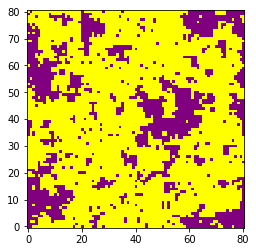

In [23]:
# Visualizing
data = []
for _ in range(1):
    i = IsingModel((81), T = 2.269) # change T to sample at different temperatures
    i.initialize()
    for _ in range(3):
        i.update_SW(3) # use the Swendsen-Wang algorithm
        # to use the Metropolis-Hastings algorithm do
        # i.update_mh(steps=10000)
    data.append(i.state)
data = np.array(data)
i.display()

In [18]:
# Generating 10000 samples and save them
"""for temp in [1, 2.269185, 5]:
    data = []
    for _ in range(10000):
        i = IsingModel((81), 2.269185)
        i.initialize()
        for _ in range(10):
            i.update_SW(1)
        data.append(i.state)
    data = np.array(data)
    np.save("ising81x81_temp_{}.npy".format(temp), data)"""

'for temp in [1, 2.269185, 5]:\n    data = []\n    for _ in range(10000):\n        i = IsingModel((81), 2.269185)\n        i.initialize()\n        for _ in range(10):\n            i.update_SW(1)\n        data.append(i.state)\n    data = np.array(data)\n    np.save("ising81x81_temp_{}.npy".format(temp), data)'

# Generate uncorrelated samples
also in `supervised_convnet/generate_uncorrelated_data.py`

In [29]:
data = np.load("supervised_convnet/t_2.269/ising81x81_temp2.269.npy")[:, :9, :9]
# print("data", data[:10])
# Create uncorrelated samples
uncorrelated_data = []
for _ in range(10000):
    # Get random block from 10000 samples
    sample = np.random.randint(0, 10000, (3, 3))
    # Pick horizontal, vertical position of 3x3 block in 9x9 block
    horizontal, vertical = np.random.randint(0, 3, (2, 3, 3))
    # Concatenate blocks
    uncorrelated = []
    for i in range(3):
        tile = []
        for j in range(3):
            tile.append(data[sample[i, j], 3*horizontal[i, j]:(3*horizontal[i, j] + 3), \
                    3*vertical[i, j]:(3*vertical[i, j] + 3)])
        uncorrelated.append(np.hstack(tile))
    uncorrelated_data.append(np.vstack(uncorrelated))

uncorrelated_data = np.array(uncorrelated_data)
print("uncorrelated_data \n", uncorrelated_data[0])
# np.save("../ising81x81_temp5_uncorrelated9x9.npy", uncorrelated_data)

uncorrelated_data 
 [[-1 -1 -1  1  1  1  1  1  1]
 [-1 -1 -1  1  1  1  1  1  1]
 [-1 -1 -1  1  1  1  1 -1 -1]
 [-1 -1 -1 -1 -1 -1  1  1  1]
 [ 1  1 -1 -1 -1 -1  1  1 -1]
 [ 1  1  1 -1 -1 -1  1  1 -1]
 [-1  1 -1 -1  1  1 -1 -1 -1]
 [ 1  1  1  1  1  1 -1 -1 -1]
 [ 1  1  1  1  1  1 -1 -1 -1]]


# Neural Network Architecture
also in `supervised_convnet/supervised_convnet.py`

In [ ]:
import torch
import torch.nn as nn
import torch.autograd as autograd
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
import math
import numpy as np
import sys

class SupervisedConvNet(nn.Module):
    def __init__(self, filter_size, square_size):
        super(SupervisedConvNet, self).__init__()
        self.filter_size = filter_size
        self.square_size = square_size
        self.leakyrelu = torch.nn.LeakyReLU(0.1)
        self.conv2d = nn.Conv2d(1, 1, filter_size, padding=0, stride = filter_size)  
        self.linear1 = nn.Linear(filter_size ** 2, 1)
        # self.linear2 = nn.Linear(100, 1)
        

    def forward(self, x):
        # add hidden layers with relu activation function
        layer1 = torch.tanh(self.conv2d(x))
        reshape = layer1.view(-1, 1, self.square_size**2)
        layer2 = torch.tanh(self.linear1(reshape))
        # layer3 = torch.tanh(self.linear2(layer2))
        # layer3 = torch.clamp(layer3, 0, 1)
        # for row in x:
        #     print("row", row)
        #     for el in row[0]:
        #         print("el", el)
        # x = torch.tanh(self.decoder(x))
        return reshape, layer2#, layer3

class IsingDataset(Dataset):
    def __init__(self, data, label):
        self.X = data
        self.y = label
        
        
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
    def __len__(self):
        return len(self.X)

def adjust_learning_rate(optimizer, epoch, lr):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = lr * (0.1 ** (epoch // 200))
    print ("learning rate", lr)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Train Neural Network to distinguish between correlated/uncorrelated samples
also in `train.py` files in each temperature subdirectory e.g. `supervised_convnet/t_2.269/train.py`

In [52]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import sys; 
from supervised_convnet import supervised_convnet
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import sys
from sklearn.model_selection import train_test_split


In [54]:
uncorrelated_data = np.load("supervised_convnet/t_2.269/ising81x81_temp2.269_uncorrelated9x9.npy")
correlated_data = np.load("supervised_convnet/t_2.269/ising81x81_temp2.269.npy")[:10000,:9,:9]
print("Uncorrelated", uncorrelated_data[0])
print("Correlated", correlated_data[0])

data = np.vstack((uncorrelated_data, correlated_data))
label = np.hstack((-np.ones(10000), np.ones(10000)))
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.33, random_state=42)
# raise ValueError

# Create training and test dataloaders
num_workers = 0
# how many samples per batch to load
batch_size = 1000
# number of epochs to train the model
n_epochs = 500
# learning rate
lr = 0.001
# adjust learning rate?
adjust_learning_rate = False

# specify loss function
criterion = nn.MSELoss()

# build model
model = supervised_convnet.SupervisedConvNet(filter_size = 3, square_size = 3)

# specify optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


# prepare data loaders
train_isingdataset = supervised_convnet.IsingDataset(X_train[:3000], y_train[:3000])
train_loader = torch.utils.data.DataLoader(train_isingdataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

validate_isingdataset = supervised_convnet.IsingDataset(X_train[-1000:], y_train[-1000:])
validate_loader = torch.utils.data.DataLoader(validate_isingdataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)



Uncorrelated [[-1 -1 -1 -1  1  1  1  1  1]
 [-1 -1 -1 -1 -1  1 -1 -1  1]
 [-1 -1 -1 -1 -1  1 -1 -1 -1]
 [-1 -1 -1  1  1  1  1  1  1]
 [-1 -1 -1  1  1  1  1  1  1]
 [-1 -1 -1  1  1  1  1  1  1]
 [ 1  1  1  1  1  1  1  1 -1]
 [ 1  1  1  1  1  1 -1 -1 -1]
 [-1  1  1  1  1  1 -1 -1 -1]]
Correlated [[ 1  1 -1  1 -1 -1 -1 -1  1]
 [ 1  1 -1 -1 -1 -1 -1 -1 -1]
 [ 1  1 -1 -1 -1  1  1  1  1]
 [-1 -1 -1 -1 -1 -1  1  1  1]
 [ 1 -1 -1 -1 -1  1  1  1  1]
 [-1 -1 -1 -1 -1  1  1  1  1]
 [-1 -1 -1 -1 -1  1  1 -1 -1]
 [-1 -1 -1 -1 -1 -1  1  1  1]
 [-1 -1  1 -1 -1 -1 -1 -1  1]]


In [56]:
for epoch in range(1, n_epochs+1):
    # monitor training loss
    accuracy = 0.0
    train_loss = 0.0
    # adjust learning rate
    if adjust_learning_rate == True:
        supervised_convnet.adjust_learning_rate(optimizer, epoch, lr)

    ###################
    # train the model #
    ###################
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.unsqueeze(1).type('torch.FloatTensor')
        target = target.type('torch.FloatTensor')
        optimizer.zero_grad()
        output = model(data)[-1].view(-1)
        loss = criterion(output, target) 
        # add regularization
        for param in model.parameters():
            loss += ((param)**2).sum()/300
        loss.backward()
        optimizer.step()

        # update running training loss
        accuracy += (torch.sign(output) == target).sum().item() / batch_size
        train_loss += loss.item() * batch_size
    
    
    # print avg training statistics 
    # train_loss = train_loss/len(train_loader)
    if epoch % 10 == 0:
        validate_accuracy = 0
        for batch_idx, (data, target) in enumerate(validate_loader):
            data = data.unsqueeze(1).type('torch.FloatTensor')
            target = target.type('torch.FloatTensor')
            output = model(data)[-1].view(-1)
            validate_accuracy += (torch.sign(output) == target).sum().item() / batch_size

        print('Epoch: {} \t Accuracy: {} \t Validate_Accuracy: {}'.format(
            epoch, 
            accuracy/len(train_loader),
            validate_accuracy/len(validate_loader),
            ))
#         print("data", data[:10])
        # print("output", (output)[:10])
        # print("target", (target)[:10])
        # for name, param in model.named_parameters():
        #     if param.requires_grad:
        #         print (name, param.data)

patience = 0
for batch_idx, (data, target) in enumerate(train_loader):
    data = data.unsqueeze(1).type('torch.FloatTensor')#[0].unsqueeze(1)
    # print("data", data)
    target = target.type('torch.FloatTensor')
    optimizer.zero_grad()
    output = [i.view(-1) for i in model(data)]
    print("data", data[:10])
    print("output", (output[:10]))
    print("target", target[:10])
    v = torch.tensor([[[[-1., -1., -1., -1., -1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1., -1.]]]])
    print("correlated model(v)", model(v))
    v = torch.tensor([[[[ 1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.],
        [ 1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.],
        [ 1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.],
        [ 1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.],
        [ 1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.],
        [ 1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.],
        [-1., -1., -1.,  1.,  1.,  1., -1., -1., -1.],
        [-1., -1., -1.,  1.,  1.,  1., -1., -1., -1.],
        [-1., -1., -1.,  1.,  1.,  1., -1., -1., -1.]]]])
    print("uncorrelated model(v)", model(v))
    # loss = criterion(output, target[0])
    # print("loss.data", loss.data)
    # loss.backward()
    patience += 1
    if patience > 100:
        break
    

v = torch.tensor([[[[-1., -1., -1., -1., -1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1., -1., -1.],
          [-1., -1., -1., -1.,  1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1., -1., -1.]]]])
print("negative", model(v))
print("positive", model(-v))


Epoch: 10 	 Accuracy: 0.47400000000000003 	 Validate_Accuracy: 0.473
Epoch: 20 	 Accuracy: 0.49866666666666665 	 Validate_Accuracy: 0.491
Epoch: 30 	 Accuracy: 0.5133333333333333 	 Validate_Accuracy: 0.507
Epoch: 40 	 Accuracy: 0.512 	 Validate_Accuracy: 0.519
Epoch: 50 	 Accuracy: 0.5076666666666666 	 Validate_Accuracy: 0.518
Epoch: 60 	 Accuracy: 0.5060000000000001 	 Validate_Accuracy: 0.525
Epoch: 70 	 Accuracy: 0.5100000000000001 	 Validate_Accuracy: 0.529
Epoch: 80 	 Accuracy: 0.514 	 Validate_Accuracy: 0.53
Epoch: 90 	 Accuracy: 0.5133333333333333 	 Validate_Accuracy: 0.535
Epoch: 100 	 Accuracy: 0.515 	 Validate_Accuracy: 0.534
Epoch: 110 	 Accuracy: 0.5156666666666667 	 Validate_Accuracy: 0.529
Epoch: 120 	 Accuracy: 0.5143333333333334 	 Validate_Accuracy: 0.527
Epoch: 130 	 Accuracy: 0.5126666666666666 	 Validate_Accuracy: 0.522
Epoch: 140 	 Accuracy: 0.512 	 Validate_Accuracy: 0.518
Epoch: 150 	 Accuracy: 0.5113333333333333 	 Validate_Accuracy: 0.511
Epoch: 160 	 Accuracy: 0.

Visualize parameters

In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print (name, param.data)

# torch.save(model.state_dict(), "9x9->3x3.pt")
    # optimizer.step()


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import glob

# Correlation check

In [3]:
size = 6561


In [133]:
state.shape

(1, 4, 2187, 2187)

In [111]:
# state = np.load("ising2187x2187_temp_1.969185.npy") # np.random.choice([-1, 1], (size, size))
def correlation_check(state = state):
    side = state.shape[2]
    means = {}
    for r in range(1, 1000):
        sisj = []
        for pic in range(1):
            state_pic = state[0, pic]
            x, y = np.random.randint(side, size = (2, 100000))
            i = np.random.randint(r, size = (100000))
            s_j = state_pic[(x + i)%side, (y - i + r)%side]
            sisj.append(s_j * state_pic[x, y])
        means[r] = np.mean(sisj)
    return means
        

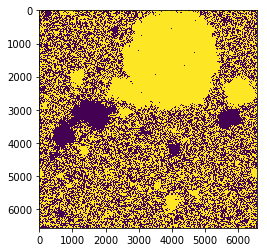

In [148]:
state = np.load("ising_samples/ising6561x6561_temp_2.269185_sample1571857139.575895.npy") # np.random.choice([-1, 1], (size, size))
plt.imshow(state)
plt.show()

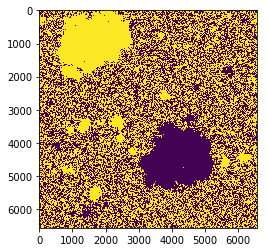

In [169]:
state = np.load("ising_samples/ising6561x6561_temp_2.269185_sample1571858818.602564.npy") # np.random.choice([-1, 1], (size, size))
plt.imshow(state)
plt.show()

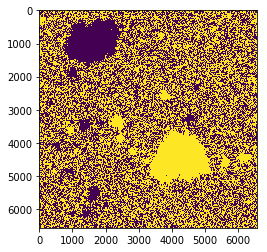

In [158]:
state = np.load("ising_samples/ising6561x6561_temp_2.269185_sample1571854227.0954611.npy") # np.random.choice([-1, 1], (size, size))
plt.imshow(state)
plt.show()

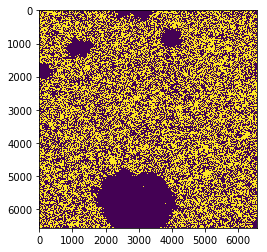

In [168]:
state = np.load("ising_samples/ising6561x6561_temp_2.269185_sample1571858426.648014.npy") # np.random.choice([-1, 1], (size, size))
plt.imshow(state)
plt.show()

In [176]:
!ls ising_2187/

ls: ising_2187/ising_2187: Not a directory


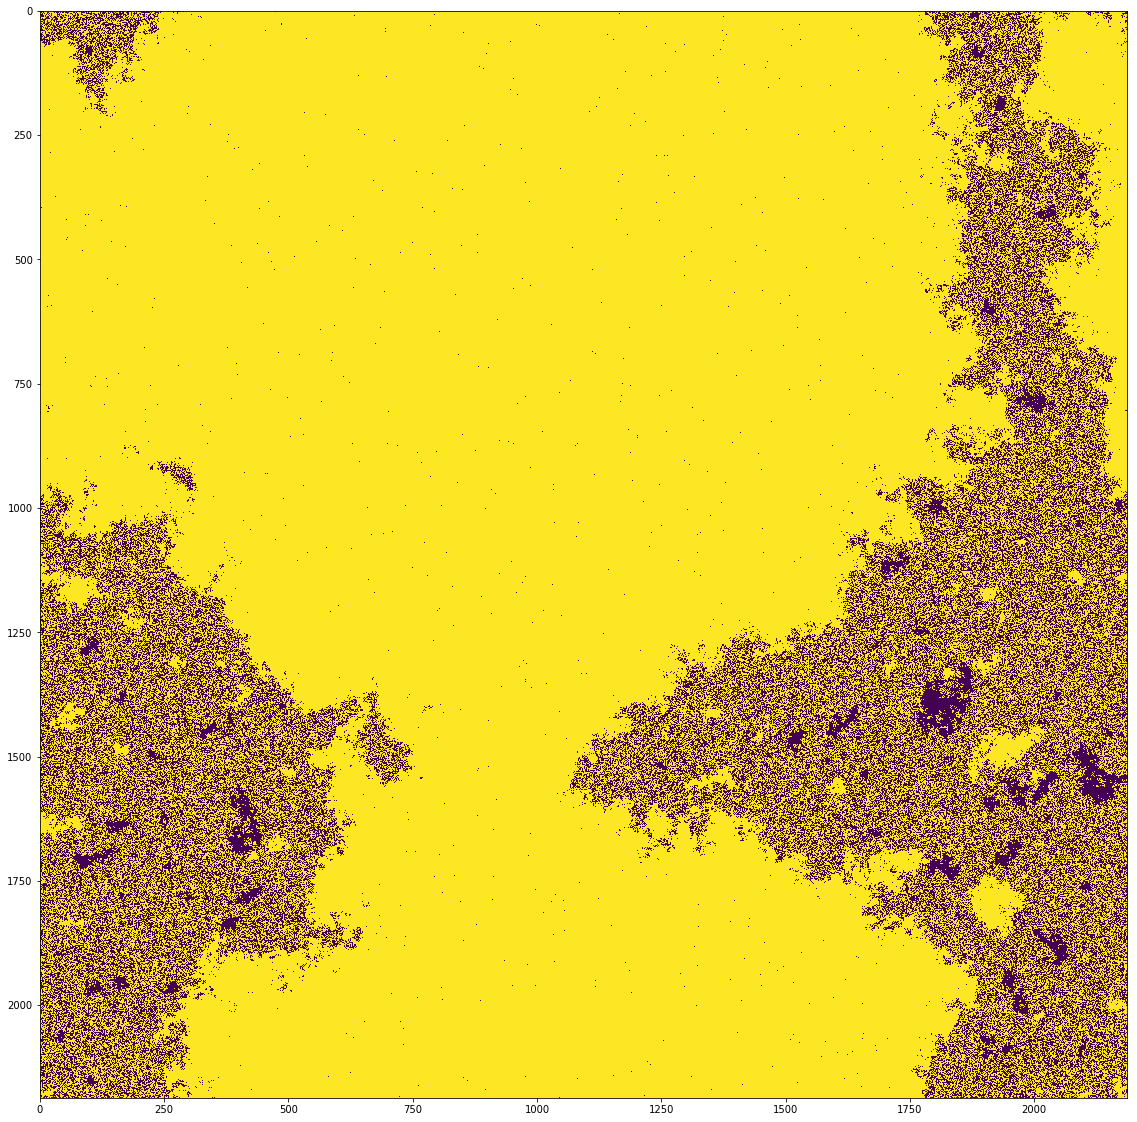

In [182]:
state = np.load("ising_2187") # np.random.choice([-1, 1], (size, size))
plt.figure(figsize=(25,20))
plt.imshow(state)
plt.show()

In [178]:
m = correlation_check(state = state[None, None, :, :])


In [155]:
func_powerlaw(2, -0.16825665,  0.45027981, -0.001)

0.40071184059018233

In [166]:
def sigmoid(x, L = 1, k = 0.002, x0 = 500):
    return L / (1 + np.exp(-k*(np.array(x)-x0)))

popt: [-0.06913295  0.83504486 -0.001     ]
popt [ 6.50998331e-01 -3.66363294e-04]


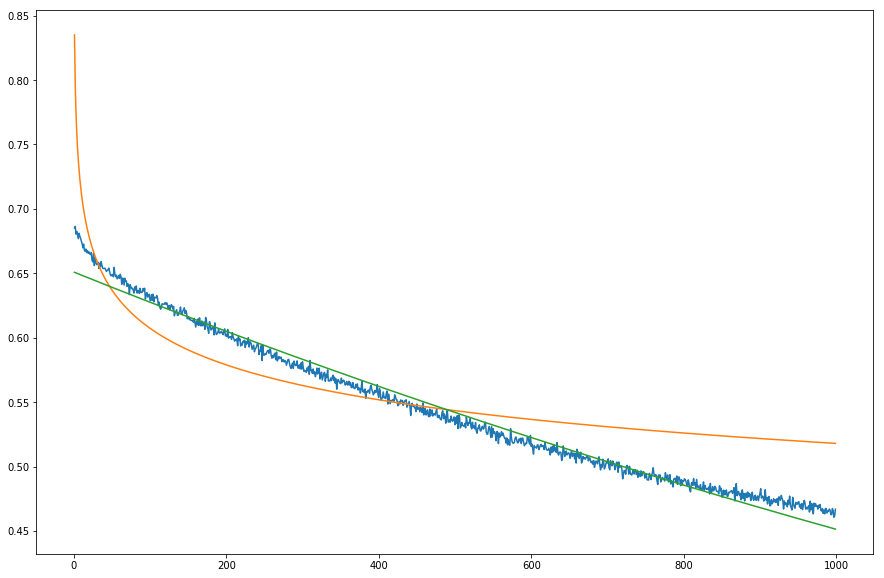

In [179]:
def func_powerlaw(x, m, c, c0):
    return x**m * c 
def func_exp(x, A, B):
    return A * np.exp(B * np.asarray(x))
target_func = func_powerlaw
k, v = list(zip(*m.items()))
plt.figure(figsize=(15,10))
plt.plot(k, v)
# plt.plot(np.array(k), target_func(np.array(k), -0.25, 0.08, 0))
popt, pcov = curve_fit(target_func, k, v, p0 = np.asarray([-0.2, 0.24, -0.001]), sigma = sigmoid(k), maxfev=20000)
print(f"popt: {popt}")
plt.plot(k, target_func(np.array(k), *popt))

target_func = func_exp
popt, pcov = curve_fit(target_func, k, v, p0 = np.asarray([0.2, -0.08]), maxfev=2000)
print(f"popt {popt}")
plt.plot(k, target_func(np.array(k), *popt))


In [33]:
popt

array([-0.3881523 ,  0.19966816,  0.        ])

In [171]:
np.mean(state[0, 1])

0.09349067493433472

In [172]:
np.mean(state[0, 2])

-0.015172375150246635

In [173]:
np.mean(state[0, 3])

-0.004341863808860145

In [101]:
np.polyfit(k, np.log(v), 1)

/Users/qanguyen/anaconda3/envs/renormalization/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


array([nan, nan])

In [99]:
v = np.asarray(v)
v[np.where(v < 0)] = 1e-10

In [94]:
np.where(v < 0)

(array([], dtype=int64),)

In [92]:
v = np.full((3,3),1)
v

array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]])

In [93]:
v[([0,0],[1,2])] *= -1

In [94]:
v

array([[ 1, -1, -1],
       [ 1,  1,  1],
       [ 1,  1,  1]])

In [101]:
v[list(zip([0,1], [0,2]))]

/Users/qanguyen/anaconda3/envs/renormalization/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """Entry point for launching an IPython kernel.


array([-1, -1])